# Get values of radar data at location of CMLs and gauges

This notebook shows how `poligrain` and its classes `GridAtPoint` and `GridAtLine` can be used to get data from a gridded product at specific points or averaged along specific lines. 

The typical use cases for this are:

- comparison of CML or SML data with weather radar data
- calculation of differences between radar and ground-based (gauges, CMLs) for radar-rainfall-adjustment

The radar data processing package `wradblib` solves this case for gridded data and points, but was not easily extendible for working with line geometries. Hence, in `poligrain` we reuse the `wradlib` approach for points and provide an implemantion for the case where we want to get gridded data along lines. For both, point and line data, we use a similar API via the classes `GridAtPoint` and `GridAtLine`.

In [1]:
import matplotlib.pyplot as plt
import xarray as xr

import poligrain as plg

## Load example data from OpenMRG

We use the gauge, radar and CML data provided by the OpenMRG dataset, see Andersson et al. 2022 https://doi.org/10.5194/essd-14-5411-2022

Here we only look at a small subest. 

Note that the CML data was processed with the simple standard processing done [here](https://github.com/OpenSenseAction/merging_prototype/blob/9cd018be263a8f5ae38bb28c1f768b353d97ffbc/radar_cml_gauge_merge_prototype.ipynb). CML data quality can be further improved with more sophisticated processing methods. For more details and an overview of methods, please refer to the CML processing package [pycomlink](https://github.com/pycomlink/pycomlink).

In [2]:
ds_cmls = xr.open_dataset("data/openMRG_cmls_20150827_12hours.nc")

ds_city_gauges = xr.open_dataset("data/openMRG_city_gauges_20150827.nc")
ds_city_gauges = ds_city_gauges.rename_dims({"station_id": "id"})
ds_city_gauges = ds_city_gauges.rename_vars({"station_id": "id"})

ds_radar = xr.open_dataset("data/openMRG_example_rad_20150827_90minutes.nc")
ds_radar.coords["lat"] = ds_radar.lat
ds_radar.coords["lon"] = ds_radar.lon

Project coordinates to UTM zone for Europe

In [3]:
# Project coordinates of city gauges
(
    ds_city_gauges.coords["x"],
    ds_city_gauges.coords["y"],
) = plg.spatial.project_point_coordinates(
    ds_city_gauges.lon,
    ds_city_gauges.lat,
    "EPSG:25832",
)

# Project coordinates of radar
(
    ds_radar.coords["x_grid"],
    ds_radar.coords["y_grid"],
) = plg.spatial.project_point_coordinates(
    ds_radar.lon,
    ds_radar.lat,
    "EPSG:25832",
)

# Project coordinates for CMLs
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, "EPSG:25832"
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, "EPSG:25832"
)

We remove very short CMLs (< 1 km) and CMLs which have frequencies below 30 GHz combined with a length below 2 km. We do this because these CMLs are fairly insensitive to rainfall and this might provide less accurate rainfall estimates. That is not say, that one cannot use rainfall estimates of these CMLs. But since CML data processing and the analysis of the resulting rainfall estimates is not the focus in this example, we remove the more insensitive CMLs.

We also select only one sublink because here, we are not interesed in comparing or leveraging the information from the two rainfall estimates of the two sublinks that each CML provides.

In [4]:
ds_cmls = ds_cmls.where(
    ~((ds_cmls.length / 1000 < 2) & (ds_cmls.frequency / 1000 < 30)), drop=True
)
ds_cmls = ds_cmls.where(ds_cmls.length / 1000 > 1, drop=True).isel(sublink_id=0)

## Quick look at data on a map

Here we first aggregate the rainfall data of all sensors to 1 hour to see the large-scale rainfall pattern

In [5]:
ds_radar_1h = ds_radar.resample(time="h", label="right").mean()
ds_city_gauges_1h = ds_city_gauges.resample(time="h", label="right").sum()
ds_cmls_1h = ds_cmls.R.resample(time="h", label="right").mean()

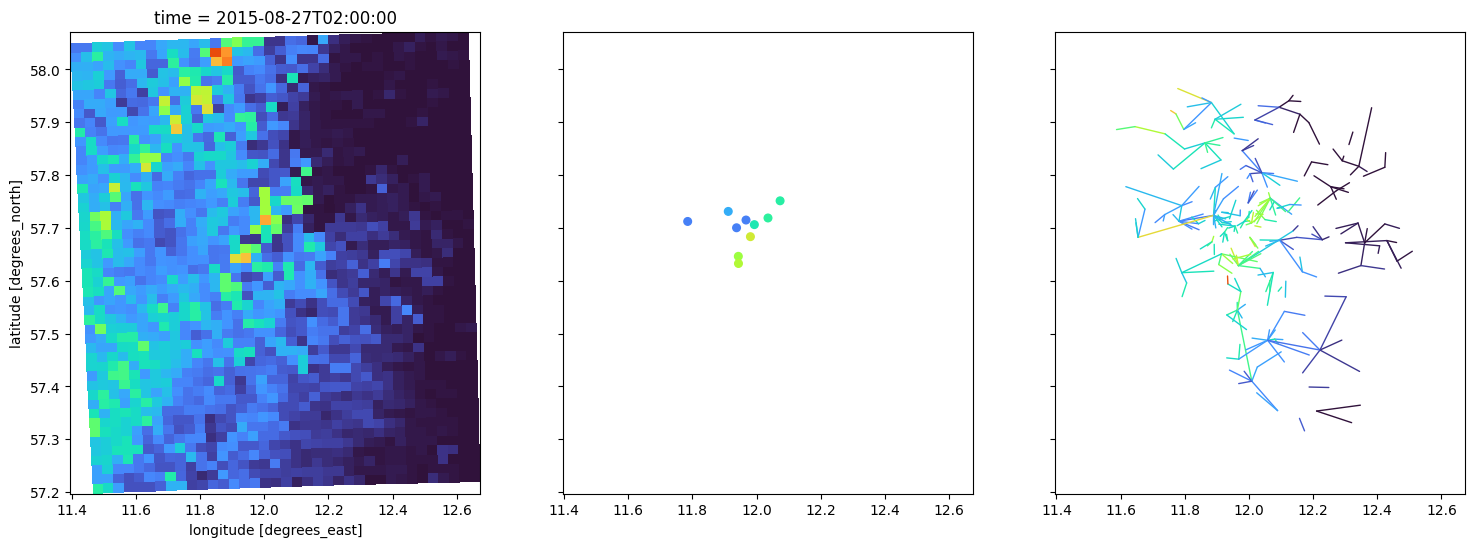

In [6]:
t = "2015-08-27T02:00:00"
vmin = 0
vmax = 10
cmap = "turbo"

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
ds_radar_1h.sel(time=t).rainfall.plot(
    x="lon", y="lat", cmap=cmap, vmin=vmin, vmax=vmax, ax=axs[0], add_colorbar=False
)
axs[1].scatter(
    ds_city_gauges.lon,
    ds_city_gauges.lat,
    c=ds_city_gauges_1h.sel(time=t).rainfall_amount,
    cmap="turbo",
    vmin=vmin,
    vmax=vmax,
    s=30,
)
ds_cmls_1h.sel(time=t).plg.plot_cmls(vmin=vmin, vmax=vmax, cmap="turbo", ax=axs[2]);

## Get radar data at gauge locations

Getting radar data at, or in the neighborhood of, a rain gauge is a common operation when working with weather radar data. Our implementation is based on what is provided by [wradlib](https://wradlib.org/) via its `wradlib.adjust.RawAtObs` class. In `poligrain` we do, however, make the usage much more easy by using `xarray.DataArray` as input and assuming that `lon` and `lat` variables as 2D grids are present.

First an object of `GridAtPoints` is created which precalculates a `KDTree` for finding the nearest neighboring grid cells for each gauge location. By doing that, the second step, calling `get_grid_at_points`, which is pointing to `GridAtPoints.__call__`, is very fast and can be done later on for other time stamps without much computational cost.

In [7]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_radar,
    da_point_data=ds_city_gauges,
    nnear=1,
    stat="best",
)

radar_at_points = get_grid_at_points(
    da_gridded_data=ds_radar.rainfall,
    da_point_data=ds_city_gauges.rainfall_amount,
)

The output is a `DataArray` with time series of the radar data at each point location. Here we show only the one for the first ID.

In [8]:
radar_at_points.isel(id=0)

<xarray.DataArray (time: 19)> Size: 152B
array([ 0.  ,  0.58,  0.  ,  0.06,  0.29,  0.27,  0.  ,  0.12,  0.36,
       57.79, 16.29,  2.58,  0.92,  1.22,  0.34,  0.06,  0.27,  0.  ,
        0.19])
Coordinates:
  * time     (time) datetime64[ns] 152B 2015-08-27T01:00:00 ... 2015-08-27T02...
    lon      float64 8B 11.94
    lat      float64 8B 57.65
    id       <U6 24B 'Jarn'

## Get radar data averaged along the CML paths

This follows the same approach as `GridAtPoints` shown above.

First an object of `GridAtLines` is created. At creation time, the grid interseection weights for each CML path are cacluated and stored as sparse matrix (more details on the grid intersection calculation are given in the [this example notebook](Grid_intersection.ipynb)). In the second step we can get the path-averaged grid values at the line locations via `get_grid_at_lines`, which is pointing to `GridAtLines.__call__`, for several time steps at very low computational cost.

Please note that for a large grid size and large number of CMLs, the initialization of `GridAtLines`, with the calculation of the grid intersection weights for each CML path, might take some minutes. For the example data shown here, it takes less then a second, though.

In [9]:
get_grid_at_lines = plg.spatial.GridAtLines(
    da_gridded_data=ds_radar,
    ds_line_data=ds_cmls,
)

In [10]:
radar_along_cml = get_grid_at_lines(da_gridded_data=ds_radar.rainfall)

The output is a `DataArray` with time series of the radar data averaged along each line. Here we show only the one for the first CML ID.

In [11]:
radar_along_cml.isel(cml_id=0)

<xarray.DataArray (time: 19)> Size: 152B
array([ 0.0522041 ,  0.        ,  0.14800615,  0.02983092,  0.60038357,
        0.31681541,  0.21003759,  0.30155104,  0.31883611, 14.12063753,
       10.99092378,  3.1945693 ,  0.72427199,  4.95591561,  2.89364268,
        0.56334212,  0.13458803,  0.21327947,  0.30953213])
Coordinates: (12/14)
    cml_id        int64 8B 10005
  * time          (time) datetime64[ns] 152B 2015-08-27T01:00:00 ... 2015-08-...
    sublink_id    <U9 36B 'sublink_1'
    site_0_lat    float64 8B 57.69
    site_0_lon    float64 8B 11.95
    site_1_lat    float64 8B 57.7
    ...            ...
    polarization  <U1 4B 'v'
    length        float64 8B 1.13e+03
    site_0_x      float64 8B 6.761e+05
    site_0_y      float64 8B 6.398e+06
    site_1_x      float64 8B 6.762e+05
    site_1_y      float64 8B 6.4e+06

## Plot resulting time series

Now we compare the time series that we derived from the radar data with the observations of the sensors. We can see that there is a quite good match in general regarding timing and magnitude. But there are also clear difference, both for gauges vs. radar and for CML vs. radar. These diffefence can be used for radar adjustment. But this is not the topic of this notebook and not the scope of `poligrain`.

### Gauge rain rates vervus the associated radar values

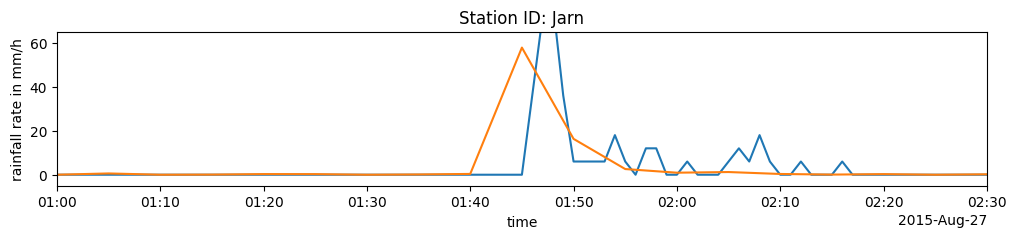

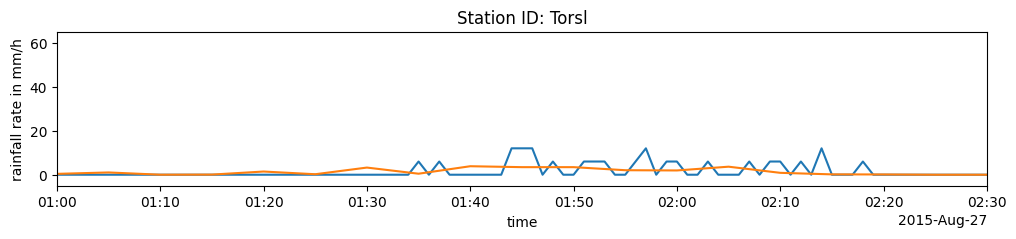

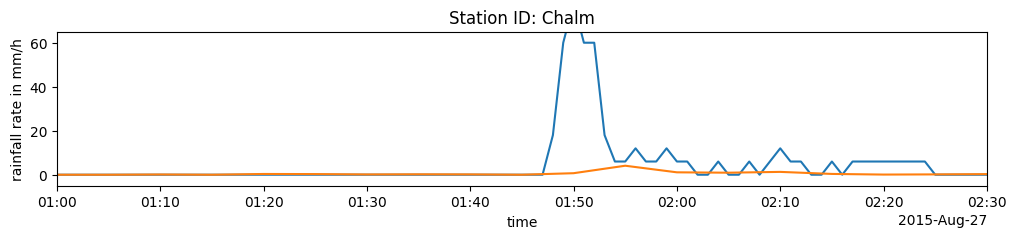

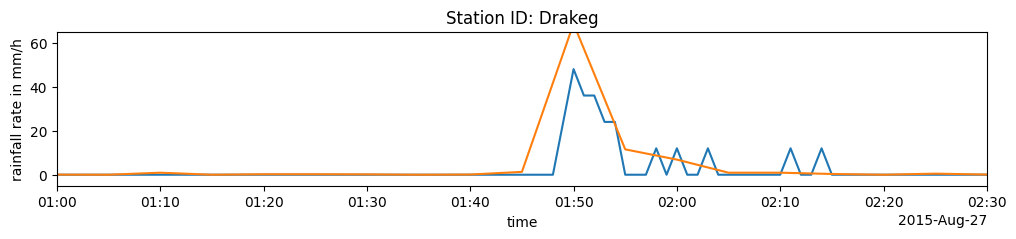

In [12]:
for i in [0, 3, 4, 7]:
    (ds_city_gauges.isel(id=i).rainfall_amount * 60).plot(figsize=(12, 2))
    radar_at_points.isel(id=i).plot()
    plt.xlim(radar_at_points.time.data[0], radar_at_points.time.data[-1])
    plt.ylim(-5, 65)
    plt.ylabel("rainfall rate in mm/h")
    plt.title(f"Station ID: {ds_city_gauges.isel(id=i).id.data}")
    plt.show()

### CML rain rates vs mean radar rain rate along CML

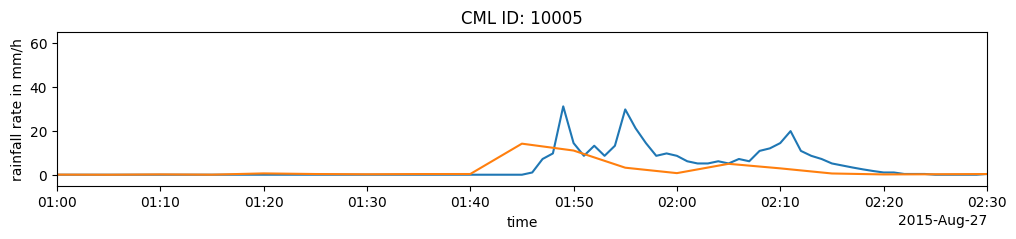

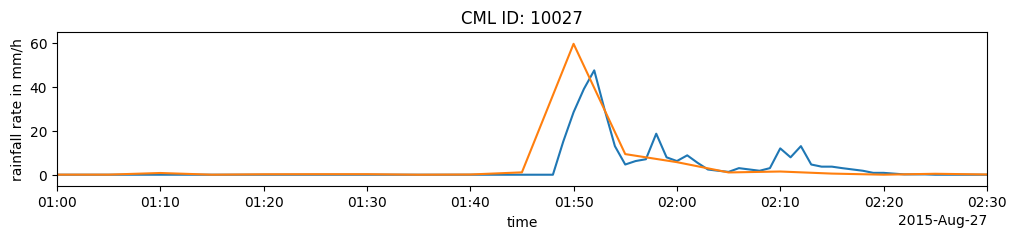

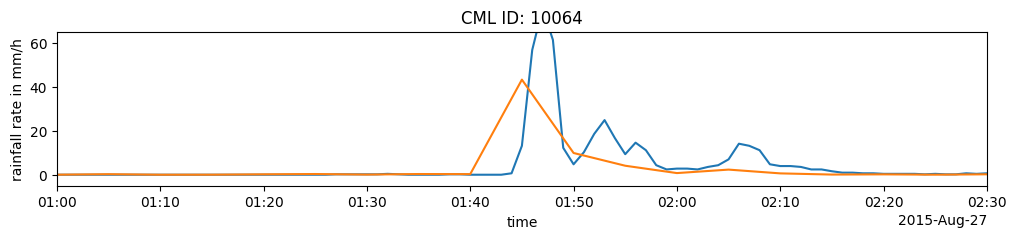

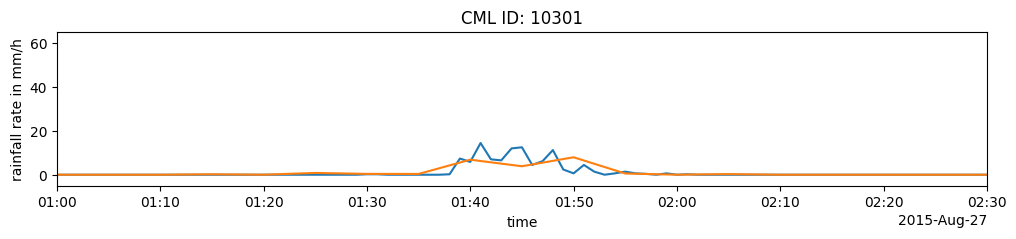

In [13]:
for i in [0, 10, 30, 210]:
    ds_cmls.isel(cml_id=i).R.plot(figsize=(12, 2))
    radar_along_cml.isel(cml_id=i).plot()
    plt.xlim(radar_along_cml.time.data[0], radar_along_cml.time.data[-1])
    plt.ylim(-5, 65)
    plt.ylabel("rainfall rate in mm/h")
    plt.title(f"CML ID: {ds_cmls.isel(cml_id=i).cml_id.data}")
    plt.show()

## Plot map of radar data at point and lines

We accumulate the rainfall rates, which stem from the 5-minute radar data in mm/h, over the full period. We plot these accumulations for the radar rainfall field, the derived radar data at the gauges and the derived path-averaged radar data for each CML.

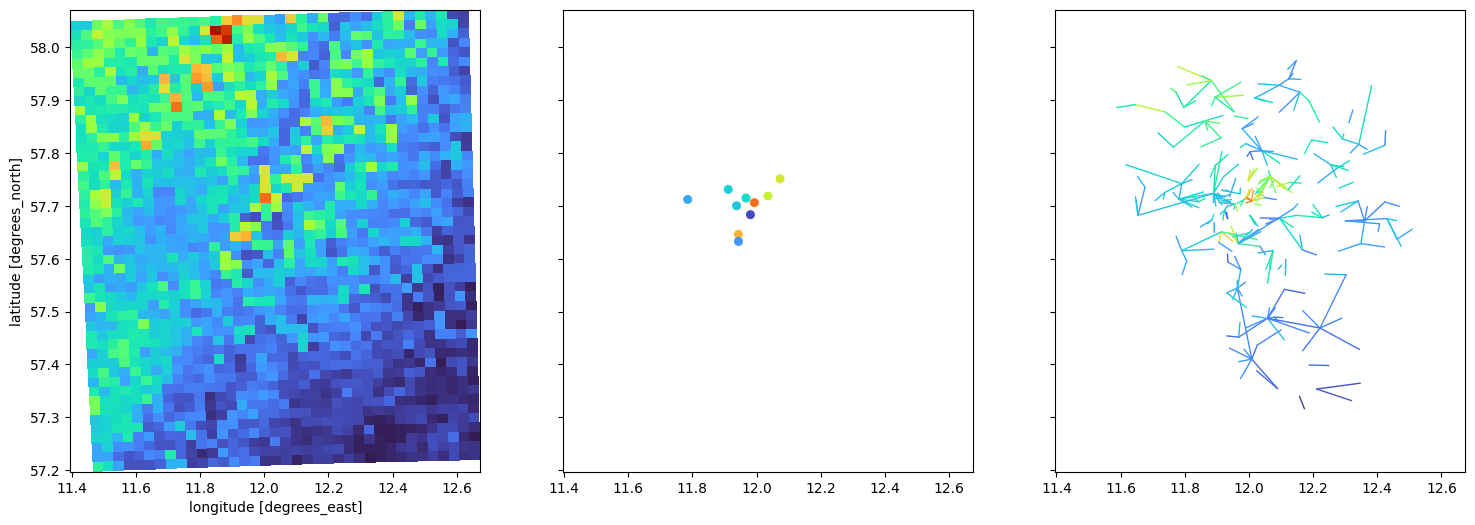

In [14]:
vmin = 0
vmax = 10
cmap = "turbo"

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
(ds_radar.rainfall.sum(dim="time") / 12).plot(
    x="lon", y="lat", cmap=cmap, vmin=vmin, vmax=vmax, ax=axs[0], add_colorbar=False
)
axs[1].scatter(
    ds_city_gauges.lon,
    ds_city_gauges.lat,
    c=(radar_at_points / 12).sum(dim="time"),
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    s=30,
)
(radar_along_cml.sum(dim="time") / 12).plg.plot_cmls(
    vmin=vmin, vmax=vmax, cmap=cmap, ax=axs[2]
);